RAVDESS DATASET DESCRIPTION: https://zenodo.org/record/1188976#.Ymh5btpByUm

In [1]:
# cloning the dataset here
repo_link = "https://github.com/vcos611/Speech-Emotion-Recognition.git"
folder_name = "SER"
!git clone $repo_link $folder_name

Cloning into 'SER'...
remote: Enumerating objects: 1466, done.
remote: Total 1466 (delta 0), reused 0 (delta 0), pack-reused 1466
Receiving objects: 100% (1466/1466), 74.32 MiB | 11.45 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Checking out files: 100% (1440/1440), done.


In [3]:
#imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display
from IPython.display import Audio
from tqdm import tqdm

import pickle
import copy

import warnings
warnings.filterwarnings('ignore')


# Loading and Pre-Processing

In [4]:
# as per the dataset description
modalities = {1:"full-AV",2:"video-only",3:"audio-only"}
channels = {1:"speech",2:"song"}
emotions = {
    0 : "neutral",
    1 : "calm",
    2 : "happy",
    3 : "sad",
    4 : "angry",
    5 : "fearful",
    6 : "disgust",
    7 : "surprised"
}
intensities = {1:"normal", 2:"strong"}
genders = {0:"female",1:"male"}

In [5]:
ravdess ,ravdess_named = [],[]

subfolders = os.listdir(f"./{folder_name}/ravdess-dataset")
for sub in subfolders:
    for file_name in os.listdir(f"./{folder_name}/ravdess-dataset/{sub}"):
        path = f"./{folder_name}/ravdess-dataset/{sub}/{file_name}"
        
        modality, channel, emotion, intensity, statement, repetition, actor = map(int,file_name[:-4].split("-"))
        gender = actor % 2
        ravdess.append([path,modality,channel,statement,intensity,repetition,actor,gender,emotion-1])
        ravdess_named.append([path,modalities[modality],channels[channel],statement,intensities[intensity],repetition,actor,genders[gender],emotions[emotion-1]])

cols = ['path','modality','channel','statement','intensity','repetition','actor','gender','emotion']
ravdess = pd.DataFrame(ravdess, columns=cols)
ravdess_named = pd.DataFrame(ravdess_named, columns=cols)
ravdess_named


,path,modality,channel,statement,intensity,repetition,actor,gender,emotion
0,./SER/ravdess-dataset/Actor_01/03-01-08-01-02-...,audio-only,speech,2,normal,1,1,male,surprised
1,./SER/ravdess-dataset/Actor_01/03-01-04-01-01-...,audio-only,speech,1,normal,1,1,male,sad
2,./SER/ravdess-dataset/Actor_01/03-01-02-01-02-...,audio-only,speech,2,normal,1,1,male,calm
3,./SER/ravdess-dataset/Actor_01/03-01-04-02-01-...,audio-only,speech,1,strong,1,1,male,sad
4,./SER/ravdess-dataset/Actor_01/03-01-05-02-02-...,audio-only,speech,2,strong,1,1,male,angry
...,...,...,...,...,...,...,...,...,...
1435,./SER/ravdess-dataset/Actor_13/03-01-05-02-02-...,audio-only,speech,2,strong,2,13,male,angry
1436,./SER/ravdess-dataset/Actor_13/03-01-03-01-01-...,audio-only,speech,1,normal,1,13,male,happy
1437,./SER/ravdess-dataset/Actor_13/03-01-05-01-02-...,audio-only,speech,2,normal,1,13,male,angry
1438,./SER/ravdess-dataset/Actor_13/03-01-08-01-02-...,audio-only,speech,2,normal,1,13,male,surprised


## Visualising Dataset Distribution

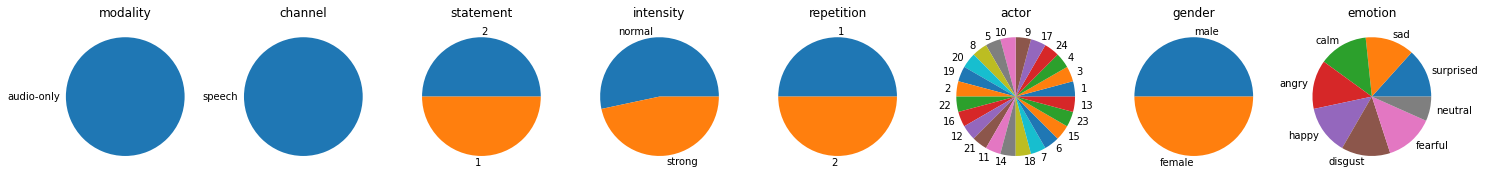

In [6]:
cols1 = ['modality','channel','statement','intensity','repetition','actor','gender','emotion']
fig, ax = plt.subplots(1,len(cols1), figsize=(25,3))
for i in range(len(cols1)):
    freq = dict(ravdess_named[cols1[i]].value_counts())
    count, label = freq.values(), freq.keys()
    ax[i].pie(count,labels=label)
    ax[i].set_title(cols1[i])
plt.show()

# Feature Engineering

In [7]:
# extracting features and adding noise to the signals

ravdess = ravdess.loc[:,['path','emotion']]
MFCC, noisedMFCC = [],[]
CHROMA, noisedCHROMA = [],[]
MELSPECTOGRAM, noisedMELSPECTOGRAM = [],[]

for i in tqdm(ravdess.index, desc="Extracting Spectogram Features"):
    wave_, sr = librosa.load(ravdess['path'][i])
    noise = np.random.normal(loc=0, scale=0.001, size=wave_.shape[0])
    noised_wave_ = wave_ + noise

    MFCC.append(np.mean(librosa.feature.mfcc(y=wave_, sr=sr).T, axis=0))
    noisedMFCC.append(np.mean(librosa.feature.mfcc(y=noised_wave_, sr=sr).T, axis=0))

    stft = np.abs(librosa.stft(wave_))
    CHROMA.append(np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0))
    noised_stft = np.abs(librosa.stft(noised_wave_))
    noisedCHROMA.append(np.mean(librosa.feature.chroma_stft(S=noised_stft, sr=sr).T, axis=0))

    MELSPECTOGRAM.append(np.mean(librosa.feature.melspectrogram(y=wave_, sr=sr).T, axis=0))
    noisedMELSPECTOGRAM.append(np.mean(librosa.feature.melspectrogram(y=noised_wave_, sr=sr).T, axis=0))

ravdess['mfcc'] = MFCC
ravdess['chroma'] = CHROMA
ravdess['melspectogram'] = MELSPECTOGRAM
ravdess['noised_mfcc'] = noisedMFCC
ravdess['noised_chroma'] = noisedCHROMA
ravdess['noised_melspectogram'] = noisedMELSPECTOGRAM

combined_spectogram = []
noised_combined_spectogram = []
for i in ravdess.index:
    combined_spectogram.append(np.concatenate((ravdess['mfcc'][i],ravdess['chroma'][i],ravdess['melspectogram'][i])))
    noised_combined_spectogram.append(np.concatenate((ravdess['noised_mfcc'][i],ravdess['noised_chroma'][i],ravdess['noised_melspectogram'][i])))
ravdess['combined_spectogram'] = combined_spectogram
ravdess['noised_combined_spectogram'] = noised_combined_spectogram

ravdess.head()

Extracting Spectogram Features: 100%|██████████| 1440/1440 [08:23<00:00,  2.86it/s]


,path,emotion,mfcc,chroma,melspectogram,noised_mfcc,noised_chroma,noised_melspectogram,combined_spectogram,noised_combined_spectogram
0,./SER/ravdess-dataset/Actor_01/03-01-08-01-02-...,7,"[-670.7761, 69.313965, -12.508771, 24.054693, ...","[0.6421743, 0.66463375, 0.7365133, 0.7386525, ...","[3.769284e-06, 3.9561408e-05, 0.003372598, 0.0...","[-436.59830911413644, 24.57659190752499, 7.990...","[0.773849989485553, 0.8175585428239159, 0.8616...","[6.772536774167888e-05, 0.00011325086004660235...","[-670.7761, 69.313965, -12.508771, 24.054693, ...","[-436.59830911413644, 24.57659190752499, 7.990..."
1,./SER/ravdess-dataset/Actor_01/03-01-04-01-01-...,3,"[-688.5531, 71.4948, -12.325982, 23.449474, -1...","[0.5899319, 0.63103294, 0.63524103, 0.61035854...","[1.494987e-06, 2.604769e-05, 0.0011618312, 0.0...","[-446.3836260872203, 20.277389677006393, 7.938...","[0.8351724612940843, 0.8457730262917332, 0.845...","[7.397355648748685e-05, 0.0001006811011758606,...","[-688.5531, 71.4948, -12.325982, 23.449474, -1...","[-446.3836260872203, 20.277389677006393, 7.938..."
2,./SER/ravdess-dataset/Actor_01/03-01-02-01-02-...,1,"[-705.9465, 78.175934, -11.913297, 25.008808, ...","[0.6142189, 0.6529227, 0.7035826, 0.7071349, 0...","[1.8651986e-06, 8.659838e-05, 0.008065977, 0.0...","[-441.4964495380858, 22.215511408449586, 8.024...","[0.7606283710249848, 0.7936640090049154, 0.833...","[6.934728678733066e-05, 0.00014221510904340574...","[-705.9465, 78.175934, -11.913297, 25.008808, ...","[-441.4964495380858, 22.215511408449586, 8.024..."
3,./SER/ravdess-dataset/Actor_01/03-01-04-02-01-...,3,"[-678.2323, 74.50636, -10.376389, 27.072632, -...","[0.68598276, 0.64086604, 0.6113875, 0.62953365...","[5.525469e-05, 3.1684318e-05, 0.0005739992, 0....","[-441.42384342978977, 23.996868243433426, 9.17...","[0.8098486419423486, 0.8217468943551913, 0.786...","[0.00013160701732790973, 9.940063241505196e-05...","[-678.2323, 74.50636, -10.376389, 27.072632, -...","[-441.42384342978977, 23.996868243433426, 9.17..."
4,./SER/ravdess-dataset/Actor_01/03-01-05-02-02-...,4,"[-417.31738, 52.110806, -36.59884, 23.725853, ...","[0.5853574, 0.6354208, 0.60773814, 0.6587769, ...","[0.0023255965, 0.0014999873, 0.0016718074, 0.0...","[-350.23752847985673, 31.636085315562887, -20....","[0.7112444392474293, 0.7630934874695011, 0.747...","[0.0023625438903690566, 0.0015764336692580716,...","[-417.31738, 52.110806, -36.59884, 23.725853, ...","[-350.23752847985673, 31.636085315562887, -20...."


## Visualising the Features

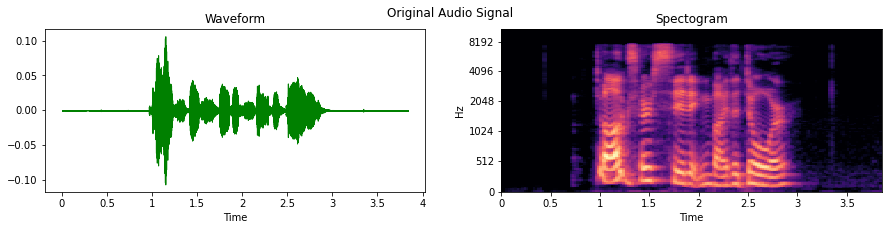

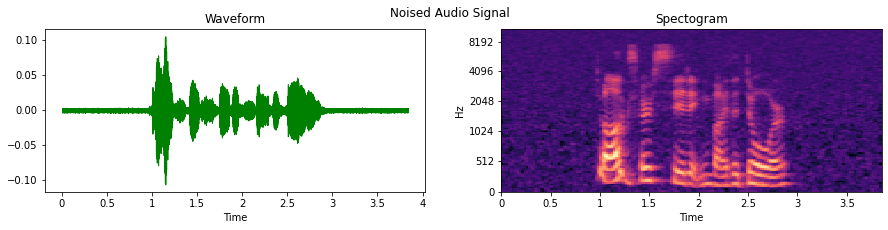

In [9]:
point = ravdess.sample(1)
wave_, sr = librosa.load(point['path'].values[0])
noise = np.random.normal(loc=0, scale=0.001, size=wave_.shape[0])
noised_wave_ = wave_ + noise

fig, ax = plt.subplots(1,2, figsize=(15,3))
fig.suptitle("Original Audio Signal")
img1 = librosa.display.waveshow(wave_,sr=sr, ax=ax[0],color='green')
ax[0].set_title("Waveform")
n_fft = 2048
hop_length = 512
mel_signal = librosa.feature.melspectrogram(y=wave_, sr=sr, hop_length=hop_length,n_fft=n_fft)
spectrogram = np.abs(mel_signal)
power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
img2 = librosa.display.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel',cmap='magma', hop_length=hop_length, ax=ax[1])
ax[1].set_title("Spectogram")
plt.show()

fig, ax = plt.subplots(1,2, figsize=(15,3))
fig.suptitle("Noised Audio Signal")
img1 = librosa.display.waveshow(noised_wave_,sr=sr, ax=ax[0],color='green')
ax[0].set_title("Waveform")
n_fft = 2048
hop_length = 512
mel_signal = librosa.feature.melspectrogram(y=noised_wave_, sr=sr, hop_length=hop_length,n_fft=n_fft)
spectrogram = np.abs(mel_signal)
power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
img2 = librosa.display.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel',cmap='magma', hop_length=hop_length, ax=ax[1])
ax[1].set_title("Spectogram")
plt.show()


# Further Pre-Processing

## Splitting the Dataset

In [10]:
# shuffling the dataset
ravdess = ravdess.sample(frac=1)
ravdess.reset_index(inplace=True, drop=True)

In [11]:
target = 'emotion'
features = [col for col in ravdess.columns if col!=target and col!='path']
X = ravdess[features]
Y = ravdess[target]

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

print("Samples in Training Set : {} [{:.2f} %]".format(len(x_train),(len(x_train)/len(X))*100))
print("Samples in Testing Set : {} [{:.2f} %]".format(len(x_test),(len(x_test)/len(X))*100))

Samples in Training Set : 1152 [80.00 %]
Samples in Testing Set : 288 [20.00 %]


In [13]:
# splitting the dataset into 8 as per the features used

x_train_mfcc = np.array([i for i in x_train['mfcc']])
x_train_chroma = np.array([i for i in x_train['chroma']])
x_train_melspectogram = np.array([i for i in x_train['melspectogram']])
x_train_combined_spectogram = np.array([i for i in x_train['combined_spectogram']])
noised_x_train_mfcc = np.array([i for i in x_train['noised_mfcc']])
noised_x_train_chroma = np.array([i for i in x_train['noised_chroma']])
noised_x_train_melspectogram = np.array([i for i in x_train['noised_melspectogram']])
noised_x_train_combined_spectogram = np.array([i for i in x_train['noised_combined_spectogram']])

x_test_mfcc = np.array([i for i in x_test['mfcc']])
x_test_chroma = np.array([i for i in x_test['chroma']])
x_test_melspectogram = np.array([i for i in x_test['melspectogram']])
x_test_combined_spectogram = np.array([i for i in x_test['combined_spectogram']])
noised_x_test_mfcc = np.array([i for i in x_test['noised_mfcc']])
noised_x_test_chroma = np.array([i for i in x_test['noised_chroma']])
noised_x_test_melspectogram = np.array([i for i in x_test['noised_melspectogram']])
noised_x_test_combined_spectogram = np.array([i for i in x_test['noised_combined_spectogram']])

y_train = np.array(np.array(y_train))
y_test = np.array(np.array(y_test))

## Scaling the Data

In [14]:
# scaling all the datasets
from sklearn.preprocessing import StandardScaler
for col in x_train.columns:
    scaler = StandardScaler()
    x_train_mfcc = scaler.fit_transform(x_train_mfcc)
    x_test_mfcc = scaler.transform(x_test_mfcc)
    x_train_chroma = scaler.fit_transform(x_train_chroma)
    x_test_chroma = scaler.transform(x_test_chroma)
    x_train_melspectogram = scaler.fit_transform(x_train_melspectogram)
    x_test_melspectogram = scaler.transform(x_test_melspectogram)
    x_train_combined_spectogram = scaler.fit_transform(x_train_combined_spectogram)
    x_test_combined_spectogram = scaler.transform(x_test_combined_spectogram)

    noised_x_train_mfcc = scaler.fit_transform(noised_x_train_mfcc)
    noised_x_test_mfcc = scaler.transform(noised_x_test_mfcc)
    noised_x_train_chroma = scaler.fit_transform(noised_x_train_chroma)
    noised_x_test_chroma = scaler.transform(noised_x_test_chroma)
    noised_x_train_melspectogram = scaler.fit_transform(noised_x_train_melspectogram)
    noised_x_test_melspectogram = scaler.transform(noised_x_test_melspectogram)
    noised_x_train_combined_spectogram = scaler.fit_transform(noised_x_train_combined_spectogram)
    noised_x_test_combined_spectogram = scaler.transform(noised_x_test_combined_spectogram)



# Trying & Testing Models

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

models = {
    'Logistic Regression': LogisticRegression(solver='lbfgs', multi_class='auto',max_iter=1000),
    'Support Vector Machine': SVC(C=1000,gamma='auto'),
    'XGBoost': XGBClassifier(learning_rate=0.3, max_depth=10),
    'LightGBM': LGBMClassifier(learning_rate=0.3,num_leaves=20,n_estimators=1000,min_child_samples=15),
    'Neural Network': MLPClassifier(alpha=0.01,batch_size=256,epsilon=1e-08,hidden_layer_sizes=(320,160,80,40),learning_rate='adaptive',max_iter=1000),
    'KNeighbors': KNeighborsClassifier(n_neighbors=5)
}
   

In [21]:
basic_score = {'combined':{'og':0,'noise':0},'mfcc':{'og':0,'noise':0},'chroma':{'og':0,'noise':0},'melspectogram':{'og':0,'noise':0}}
scores = {mod : copy.deepcopy(basic_score) for mod in models}

for mod in tqdm(models, desc='Trying Models'):
    model = models[mod]

    model.fit(x_train_combined_spectogram, y_train)
    scores[mod]['combined']['og'] = accuracy_score(y_test, model.predict(x_test_combined_spectogram))
    model.fit(x_train_mfcc, y_train)
    scores[mod]['mfcc']['og'] = accuracy_score(y_test, model.predict(x_test_mfcc))
    model.fit(x_train_chroma, y_train)
    scores[mod]['chroma']['og'] = accuracy_score(y_test, model.predict(x_test_chroma))
    model.fit(x_train_melspectogram, y_train)
    scores[mod]['melspectogram']['og'] = accuracy_score(y_test, model.predict(x_test_melspectogram))

    model.fit(noised_x_train_combined_spectogram, y_train)
    scores[mod]['combined']['noise'] = accuracy_score(y_test, model.predict(noised_x_test_combined_spectogram))
    model.fit(noised_x_train_mfcc, y_train)
    scores[mod]['mfcc']['noise'] = accuracy_score(y_test, model.predict(noised_x_test_mfcc))
    model.fit(noised_x_train_chroma, y_train)
    scores[mod]['chroma']['noise'] = accuracy_score(y_test, model.predict(noised_x_test_chroma))
    model.fit(noised_x_train_melspectogram, y_train)
    scores[mod]['melspectogram']['noise'] = accuracy_score(y_test, model.predict(noised_x_test_melspectogram))
    

    

Trying Models: 100%|██████████| 6/6 [04:02<00:00, 40.41s/it]


## Tabulating the Results

In [23]:
# Tabulating the Results
print("{:<30}{:<30}{:<30}{:<30}{:<30}".format("MODEL", "MFCC", "CHROMA","MEL SPEC","COMBINED"))
print("{:<30}{:<12}{:<18}{:<12}{:<18}{:<12}{:<18}{:<12}{:<18}".format("","Original","Noised","Original","Noised","Original","Noised","Original","Noised"))
print()
for mod in models:
    print("{:<30}{:<12.4f}{:<18.4f}{:<12.4f}{:<18.4f}{:<12.4f}{:<18.4f}{:<12.4f}{:<18.4f}".format(
        mod,
        scores[mod]['mfcc']['og'],
        scores[mod]['mfcc']['noise'],
        scores[mod]['chroma']['og'],
        scores[mod]['chroma']['noise'],
        scores[mod]['melspectogram']['og'],
        scores[mod]['melspectogram']['noise'],
        scores[mod]['combined']['og'],
        scores[mod]['combined']['noise']
    ))

MODEL                         MFCC                          CHROMA                        MEL SPEC                      COMBINED                      
                              Original    Noised            Original    Noised            Original    Noised            Original    Noised            

Logistic Regression           0.4479      0.4618            0.1458      0.1910            0.3333      0.3472            0.4931      0.5174            
Support Vector Machine        0.6979      0.5938            0.2326      0.2049            0.3160      0.2361            0.5903      0.5451            
XGBoost                       0.5729      0.5660            0.1944      0.2396            0.5243      0.4653            0.5694      0.5903            
LightGBM                      0.5833      0.5972            0.2049      0.2049            0.5417      0.5417            0.6250      0.6111            
Neural Network                0.6701      0.6285            0.2118      0.2326            0.4

## Plotting the Results

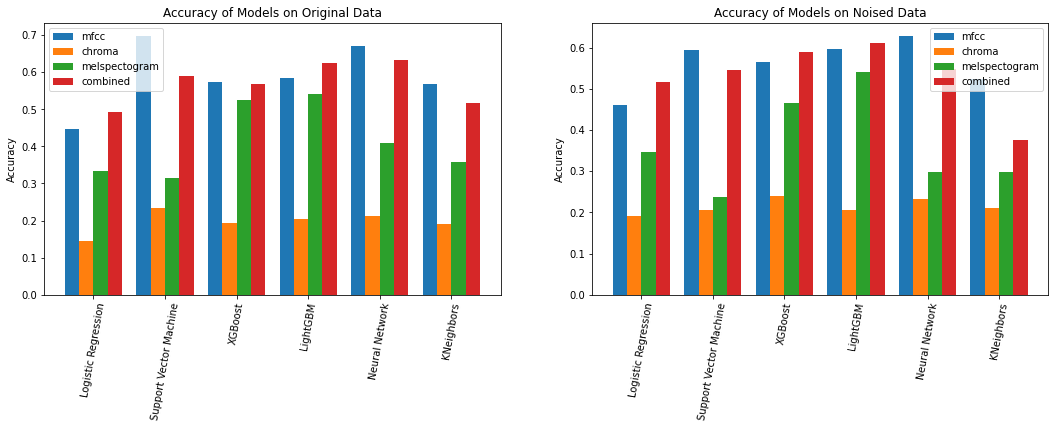

In [24]:
# plotting the results
fig, ax = plt.subplots(1,2,figsize=(18,5))
x_axis = np.arange(len(models))
offset = -0.3
model_names = list(models.keys())
for spec in ['mfcc','chroma','melspectogram','combined']:
    ax[0].bar(x_axis+offset,[scores[mod][spec]['og'] for mod in model_names],width=0.2, label=spec)
    offset += 0.2
ax[0].set_xticks(x_axis)
ax[0].set_xticklabels(model_names, rotation=80)
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy of Models on Original Data")
ax[0].legend()

x_axis = np.arange(len(models))
offset = -0.3
for spec in ['mfcc','chroma','melspectogram','combined']:
    ax[1].bar(x_axis+offset,[scores[mod][spec]['noise'] for mod in model_names],width=0.2, label=spec)
    offset += 0.2
ax[1].set_xticks(x_axis)
ax[1].set_xticklabels(model_names, rotation=80)
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy of Models on Noised Data")
ax[1].legend()

# fig.tight_layout()
plt.show()

# Tuning the Models

## Tuning SVM

In [25]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
parameters={'C':[1,2000],'kernel':['rbf','sigmoid']}
svc = SVC()
clf=GridSearchCV(svc,parameters)
clf.fit(x_train_mfcc, y_train)
y_pred = clf.predict(x_test_mfcc)
print("Best Accuracy:",accuracy_score(y_test, y_pred))
print("Best Parameters:",clf.best_params_)

Best Accuracy: 0.6979166666666666
Best Parameters: {'C': 2000, 'kernel': 'rbf'}


In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.62      0.68      0.65        19
           1       0.74      0.92      0.82        38
           2       0.71      0.63      0.67        43
           3       0.82      0.69      0.75        39
           4       0.77      0.74      0.76        50
           5       0.59      0.65      0.62        34
           6       0.59      0.59      0.59        34
           7       0.67      0.65      0.66        31

    accuracy                           0.70       288
   macro avg       0.69      0.69      0.69       288
weighted avg       0.70      0.70      0.70       288



## Tuning MLP

In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
parameters={
    'hidden_layer_sizes':[(320),(320,160),(320,160,80,40)],
    'activation':['logistic','tanh','relu']
}
mlp = MLPClassifier()
clf=GridSearchCV(mlp,parameters)
clf.fit(x_train_mfcc, y_train)
y_pred = clf.predict(x_test_mfcc)
print("Best Accuracy:",accuracy_score(y_test, y_pred))
print("Best Parameters:",clf.best_params_)


Best Accuracy: 0.7118055555555556
Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (320, 160, 80, 40)}


In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.63      0.67        19
           1       0.80      0.84      0.82        38
           2       0.71      0.58      0.64        43
           3       0.74      0.74      0.74        39
           4       0.83      0.80      0.82        50
           5       0.55      0.65      0.59        34
           6       0.62      0.68      0.65        34
           7       0.69      0.71      0.70        31

    accuracy                           0.71       288
   macro avg       0.71      0.70      0.70       288
weighted avg       0.72      0.71      0.71       288



## Tuning XG Boost

In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
parameters={
    'max_depth':[3,5,7],
    'learning_rate':[0.1,0.5,0.9],
    'n_estimators':[100,500,1000]
}
xgb = XGBClassifier()
clf=GridSearchCV(xgb,parameters)
clf.fit(x_train_mfcc, y_train)
y_pred = clf.predict(x_test_mfcc)
print("Best Accuracy:",accuracy_score(y_test, y_pred))
print("Best Parameters:",clf.best_params_)


Best Accuracy: 0.5729166666666666
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}


In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.54      0.37      0.44        19
           1       0.57      0.74      0.64        38
           2       0.61      0.47      0.53        43
           3       0.57      0.67      0.61        39
           4       0.77      0.68      0.72        50
           5       0.53      0.59      0.56        34
           6       0.45      0.41      0.43        34
           7       0.47      0.52      0.49        31

    accuracy                           0.57       288
   macro avg       0.56      0.55      0.55       288
weighted avg       0.58      0.57      0.57       288



# Saving the Model for deployment

Final Model and options chosen <br>
Model: MLP with best parameter from grid search<br>
Noise: Going without adding noise to singals<br>
Feature Space: Using only MFCC<br>

In [32]:
# combining train and test data
X = np.array([i for i in ravdess['mfcc']])
Y = np.array(ravdess['emotion'])

# final Scaler
scaler = StandardScaler()
scaler.fit_transform(X)
with open('scaler.sav','wb') as file:
    pickle.dump(scaler, file)

# final MLP
final_model = MLPClassifier(
    activation='tanh',
    hidden_layer_sizes=(320, 160, 80, 40)
)
final_model.fit(X, Y)
with open('model.sav','wb') as file:
    pickle.dump(final_model, file)

# BIBLIOGRAPHY
<br> https://blog.dataiku.com/speech-emotion-recognition-deep-learning
<br> https://vivoka.com/how-to-speech-emotion-recognition/
<br>